## CS365 Final Project

### Libraries

In [2]:
import os
import random, string, re, spacy
import torch
import pandas as pd
import numpy as np
from datasets import load_metric
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
import nltk
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

### Data Processing

In [3]:
#cleaning
def text_cleaner(text):
    #remove words between ()
    cleaned_string = ""
    paren_depth = 0
    for c in text:
        if c == '(':
            paren_depth += 1
        elif c == ')' and paren_depth:
            paren_depth -= 1
        elif paren_depth == 0:
            cleaned_string += c

    newString = cleaned_string.lower()
    newString = re.sub('"','', newString)  
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 

    tokens = newString.split()
    long_words = [i for i in tokens if len(i) > 1]

    return (" ".join(long_words)).strip()


In [4]:
#training data
paper_data_lstm = []
abstract_data_lstm = []

vocab_dict = {}

#File
paper_file_path = [
    "Comp_Ling_paper_{}.txt".format(i) for i in range(1, 101)
]
abstract_file_path = [
    "abstract_{}.txt".format(i) for i in range(1, 101)
]

for i in range(len(paper_file_path)):
    with open(paper_file_path[i], "r") as f:
        paper = f.read()

    with open(abstract_file_path[i], "r") as f:
        abstract = f.read()
    
    cleaned_paper = text_cleaner(paper)
    cleaned_abstract = text_cleaner(abstract)

    #Tokenization
    nlp = spacy.load("en_core_web_sm")

    paper_tokens = [tok.text for tok in nlp(cleaned_paper)]
    abstract_tokens = ['<sos>'] + [tok.text for tok in nlp(cleaned_abstract)] + ['<eos>']

    for token in paper_tokens:
        if token not in vocab_dict:
            vocab_dict[token] = len(vocab_dict)
    for token in abstract_tokens:
        if token not in vocab_dict:
            vocab_dict[token] = len(vocab_dict)
            
    paper_data_lstm.append(paper_tokens)
    abstract_data_lstm.append(abstract_tokens)


In [5]:
#test data
test_paper = 'paper_ex.txt'
#test_paper = "Comp_Ling_paper_2.txt"
with open(test_paper, "r") as f:
    test_text = f.read()

cleaned_example = text_cleaner(test_text)
test_tokens_original = word_tokenize(cleaned_example)

for token in test_tokens_original:
        if token not in vocab_dict:
            vocab_dict[token] = len(vocab_dict)
test_tokens = test_tokens_original[:2132]
test_vocab = {token: idx for idx, token in enumerate(set(test_tokens))}
test_vocab_size  = len(test_vocab)
vocab_dict.update(test_vocab)


In [6]:
vocab_size = []
paper_input = []
abstract_input = []
for i in range(len(paper_data_lstm)):
    paper_vocab = {token: idx for idx, token in enumerate(set(paper_data_lstm[i]))}
    abstract_vocab = {token: idx for idx, token in enumerate(set(abstract_data_lstm[i]))}

    vocab_size.append([len(paper_vocab), len(abstract_vocab)])

    paper_indices = [paper_vocab[token] for token in paper_data_lstm[i]]
    abstract_indices = [abstract_vocab[token] for token in abstract_data_lstm[i]]

    paper_indices_tensor = torch.tensor(paper_indices)
    abstract_indices_tensor = torch.tensor(abstract_indices)

    paper_input.append(paper_indices_tensor)
    abstract_input.append(abstract_indices_tensor)

### LSTM

In [7]:
class MyDataset(Dataset):
    def __init__(self, paper_data, abstract_data):
        self.paper_data = paper_data
        self.abstract_data = abstract_data

    def __len__(self):
        return len(self.paper_data)

    def __getitem__(self, idx):
        return self.paper_data[idx], self.abstract_data[idx]

class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, (hidden, cell) = self.rnn(embedded)
        return hidden, cell

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout, batch_first=True)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        input = input.unsqueeze(1)
        embedded = self.dropout(self.embedding(input))
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        prediction = self.fc_out(output.squeeze(1))
        return prediction, hidden, cell

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.output_dim
        
        # tensor to store decoder outputs
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)
        
        # last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        # first input to the decoder is the <sos> tokens
        input = trg[:,0]
        
        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[:,t,:] = output
            # decide if we will use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            # get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            # if teacher forcing, use actual next token as next input. If not, use predicted token
            input = trg[:,t] if teacher_force else top1
        
        return outputs


In [8]:
def validate(model, val_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    with torch.no_grad():  # Disable gradient computation
        for paper_data, abstract_data in val_loader:
            paper_data, abstract_data = paper_data.to(device), abstract_data.to(device)
            output = model(paper_data, abstract_data)
            output_dim = output.shape[-1]
            output = output[1:].reshape(-1, output_dim)
            target = abstract_data[1:].contiguous().view(-1)
            loss = criterion(output, target)
            total_loss += loss.item()
    return total_loss / len(val_loader)

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs  = 100
batch_size = 512

def my_collate_fn(batch):
    paper_batch, abstract_batch = zip(*batch)
    paper_padded = pad_sequence(paper_batch, batch_first=True, padding_value=0)
    abstract_padded = pad_sequence(abstract_batch, batch_first=True, padding_value=0)
    return paper_padded, abstract_padded

paper_train, paper_val, abstract_train, abstract_val = train_test_split(
    paper_input, abstract_input, test_size=0.2, random_state=42
)

train_dataset = MyDataset(paper_train, abstract_train)
val_dataset = MyDataset(paper_val, abstract_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=my_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=my_collate_fn)

INPUT_DIM = 3000
OUTPUT_DIM = 500
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

encoder = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
decoder = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(encoder, decoder, device).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()


#Training
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_idx, (paper_data, abstract_data) in enumerate(train_loader):
        paper_data, abstract_data = paper_data.to(device), abstract_data.to(device)
        optimizer.zero_grad()

        decoder_input = abstract_data[:, :-1]
        output = model(paper_data, decoder_input)
        output_dim = output.shape[-1]
        output = output.reshape(-1, output_dim)

        #masking
        target = abstract_data[:, 1:].reshape(-1) 
        mask = target != 0

        output = output[mask]
        target = target[mask]
        
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    avg_val_loss = validate(model, val_loader, criterion, device)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}')

torch.save(model.state_dict(), 'lstm_summarization_model_512_100_lr.pth')

Epoch [1/100], Train Loss: 6.213346004486084, Val Loss: 6.231729507446289
Epoch [2/100], Train Loss: 6.212118625640869, Val Loss: 6.228188991546631
Epoch [3/100], Train Loss: 6.210633277893066, Val Loss: 6.228956699371338
Epoch [4/100], Train Loss: 6.209063529968262, Val Loss: 6.227612495422363
Epoch [5/100], Train Loss: 6.207563877105713, Val Loss: 6.229526996612549
Epoch [6/100], Train Loss: 6.20583438873291, Val Loss: 6.227306365966797
Epoch [7/100], Train Loss: 6.204083442687988, Val Loss: 6.225395679473877
Epoch [8/100], Train Loss: 6.202177047729492, Val Loss: 6.224236965179443
Epoch [9/100], Train Loss: 6.200571060180664, Val Loss: 6.225518226623535
Epoch [10/100], Train Loss: 6.19877290725708, Val Loss: 6.223486423492432
Epoch [11/100], Train Loss: 6.1970438957214355, Val Loss: 6.224047660827637
Epoch [12/100], Train Loss: 6.194667816162109, Val Loss: 6.223669052124023
Epoch [13/100], Train Loss: 6.192975044250488, Val Loss: 6.221007347106934
Epoch [14/100], Train Loss: 6.19067

In [16]:
def generate_summary(model, tokens, paper_vocab, device):
    text_indices = [paper_vocab[token] for token in tokens]
    paper_data_tensor = torch.tensor(text_indices).unsqueeze(0).to(device)
    model.eval()
    
    with torch.no_grad():
        #seq2seq
        hidden, cell = model.encoder(paper_data_tensor)
        trg = torch.tensor([paper_vocab['<sos>']]).to(device)

        generated_tokens = []


        for _ in range(198): #max summary length
            output, hidden, cell = model.decoder(trg, hidden, cell)
            output_probs = F.softmax(output, dim=1)
            predicted_token = torch.multinomial(output_probs, 1).item()
            generated_tokens.append(predicted_token)

            if predicted_token == paper_vocab['<eos>'] or len(generated_tokens) >= 198:
                break

            trg = torch.tensor([predicted_token]).to(device)

    return generated_tokens

model = Seq2Seq(encoder, decoder, device)
model.load_state_dict(torch.load('lstm_summarization_model_512_50_lr.pth', map_location=device))
model.eval()

summary_tokens = generate_summary(model, test_tokens, vocab_dict, device)

def get_key_from_value(dictionary, target_value):
    for key, value in dictionary.items():
        if value == target_value:
            return key
    return ' '

summary_text = ''
for token in summary_tokens:
    word  = get_key_from_value(vocab_dict, token)
    summary_text += word
    summary_text += ' '

print("Generated Summary:")
print(summary_text)

Generated Summary:
session information often released performance   sources accurate yet its mean generative issues plm issues usually information or potheses plm solo underlying yet attribution natural data solo or grounded known discourse harrison performance motivating good known semantic develop known was framework hallucination motivating embeddings we or or develop neural summarization album issues good summarization is often like framework including george plm responses which often ystem generative related old harrison number hallucination of known conduct observe example develop attribution find conduct attribution information design including for early key large lacking nuanced across documents source generative related underlying accurate cases motivating systems for or number nlg   yet sources source data attribution conduct of sources respect dialogue by embeddings design cases design advanced system advanced november thing documents advanced example system mean evaluation 

### Evaluation

In [17]:
def calculate_rouge_scores(predictions, references):
    rouge = load_metric("rouge")
    results = rouge.compute(predictions=predictions, references=references)
    return results

#test data
test_abstract = 'abstract_ex.txt'

with open(test_paper, "r") as f:
    test_abs = f.read()

cleaned_example_abstract = text_cleaner(test_abs)

# example summary and reference summary
generated_summary = summary_text
reference_summary = cleaned_example_abstract

GPT_summary = 'The text discusses automatic readability assessment (ARA) and its evolution from relying on manually selected linguistic features to incorporating pre-trained language models (PLMs). It highlights a recent shift towards integrating linguistic features with PLMs to enhance readability classification, particularly for long passages. Through experiments, the text reveals that linguistic features predominantly benefit PLMs in assessing longer passages, with their effectiveness diminishing as dataset size increases. Additionally, it suggests that the Newsela dataset may not be ideal for ARA purposes.'
GPT_summary_full = 'This paper explores the automatic assessment of readability levels in texts, crucial for language learners, by examining the evolution of readability assessment methods from traditional formulas to modern deep learning models. While deep learning models have shown promise, challenges remain due to limited dataset sizes and the complexity of long passages. To address this, the paper proposes integrating linguistic features with pre-trained language models (PLMs) and conducts experiments to analyze their impact, particularly on long passages. Findings reveal that even simple linguistic features significantly improve PLM accuracy on small datasets, particularly on long passages, although their effectiveness diminishes as dataset sizes increase beyond a certain threshold. Moreover, the paper suggests that the Newsela dataset might not be suitable for Automatic Readability Assessment (ARA) due to overlap between simplification levels and readability levels, and introduces a new dataset, RAZ, sourced from leveled books of RAZ-Kid2, enhancing practicality in research. Detailed analyses, error breakdowns, and experimental results support these conclusions, shedding light on the interplay between linguistic features and PLMs in ARA.'
# Calculate ROUGE scores
rouge_scores = calculate_rouge_scores([generated_summary], [reference_summary])
rouge_scores_gpt = calculate_rouge_scores([GPT_summary], [reference_summary])
rouge_scores_gpt_full = calculate_rouge_scores([GPT_summary_full], [reference_summary])

# Print ROUGE scores
print("Generated Summary")
for key, value in rouge_scores.items():
    print(f"{key}: {value.mid.precision:.4f} (Precision), {value.mid.recall:.4f} (Recall), {value.mid.fmeasure:.4f} (F1 Score)")
print("GPT Summary")
for key, value in rouge_scores_gpt.items():
    print(f"{key}: {value.mid.precision:.4f} (Precision), {value.mid.recall:.4f} (Recall), {value.mid.fmeasure:.4f} (F1 Score)")
print("GPT Summary Full")
for key, value in rouge_scores_gpt_full.items():
    print(f"{key}: {value.mid.precision:.4f} (Precision), {value.mid.recall:.4f} (Recall), {value.mid.fmeasure:.4f} (F1 Score)")




/Users/seungmincho/anaconda3/lib/python3.11/site-packages/datasets/load.py:756: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/Users/seungmincho/anaconda3/lib/python3.11/site-packages/datasets/load.py:756: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to

Generated Summary
rouge1: 0.1949 (Precision), 0.0591 (Recall), 0.0907 (F1 Score)
rouge2: 0.0000 (Precision), 0.0000 (Recall), 0.0000 (F1 Score)
rougeL: 0.0821 (Precision), 0.0249 (Recall), 0.0382 (F1 Score)
rougeLsum: 0.0821 (Precision), 0.0249 (Recall), 0.0382 (F1 Score)
GPT Summary
rouge1: 0.6500 (Precision), 0.0809 (Recall), 0.1438 (F1 Score)
rouge2: 0.1899 (Precision), 0.0234 (Recall), 0.0416 (F1 Score)
rougeL: 0.4250 (Precision), 0.0529 (Recall), 0.0941 (F1 Score)
rougeLsum: 0.4250 (Precision), 0.0529 (Recall), 0.0941 (F1 Score)
GPT Summary Full
rouge1: 0.6337 (Precision), 0.1695 (Recall), 0.2675 (F1 Score)
rouge2: 0.1754 (Precision), 0.0467 (Recall), 0.0738 (F1 Score)
rougeL: 0.3663 (Precision), 0.0980 (Recall), 0.1546 (F1 Score)
rougeLsum: 0.3663 (Precision), 0.0980 (Recall), 0.1546 (F1 Score)


/Users/seungmincho/anaconda3/lib/python3.11/site-packages/datasets/load.py:756: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


### Analysis

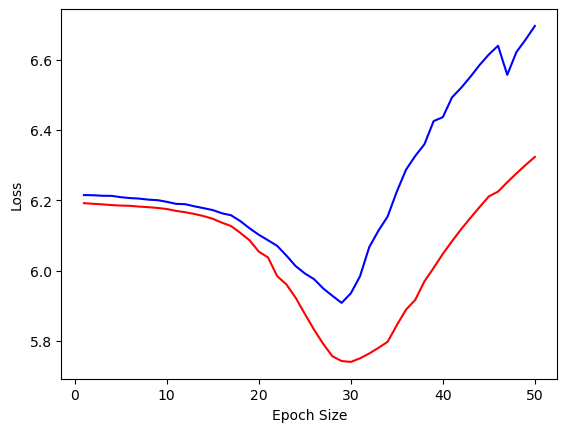

In [18]:
#Batch size

Epoch_list = [x for x in range(1,51)]

#Val loss with different batch size
batch_256 = [
    6.21519136428833, 6.214724063873291, 6.2131805419921875, 6.212952613830566, 6.209162712097168,
    6.206629276275635, 6.205130100250244, 6.202194690704346, 6.200684547424316, 6.196010112762451,
    6.190285682678223, 6.189253330230713, 6.183204174041748, 6.1779584884643555, 6.172473430633545,
    6.163381099700928, 6.157585144042969, 6.140994071960449, 6.1206207275390625, 6.1023268699646,
    6.086754322052002, 6.0707502365112305, 6.043216228485107, 6.013437747955322, 5.99238920211792,
    5.97622013092041, 5.949806213378906, 5.928738594055176, 5.908694267272949, 5.935765266418457,
    5.984397888183594, 6.066954135894775, 6.1137919425964355, 6.154195785522461, 6.2250142097473145,
    6.287292003631592, 6.326328277587891, 6.359646797180176, 6.425377368927002, 6.436675071716309,
    6.492900371551514, 6.520322799682617, 6.55157995223999, 6.585103511810303, 6.6147894859313965,
    6.639636039733887, 6.556909084320068, 6.6218414306640625, 6.657279014587402, 6.69598913192749
]

batch_512 = [
    6.192203044891357, 6.190314769744873, 6.188745498657227, 6.186720371246338, 6.1852126121521,
    6.184574604034424, 6.182371139526367, 6.180751323699951, 6.178526401519775, 6.175586700439453,
    6.170106887817383, 6.166388988494873, 6.161497116088867, 6.1553568840026855, 6.147785663604736,
    6.136656284332275, 6.12692403793335, 6.1074748039245605, 6.086592197418213, 6.054471492767334,
    6.03786039352417, 5.98466157913208, 5.961151123046875, 5.9235968589782715, 5.87762975692749,
    5.8328328132629395, 5.792041778564453, 5.756974220275879, 5.743349552154541, 5.740853786468506,
    5.7511372566223145, 5.764797687530518, 5.780789852142334, 5.798075199127197, 5.845339298248291,
    5.889374732971191, 5.917327404022217, 5.969769477844238, 6.008025169372559, 6.048081398010254,
    6.084068298339844, 6.118463039398193, 6.150363445281982, 6.181362628936768, 6.211269855499268,
    6.225076198577881, 6.251622200012207, 6.2768402099609375, 6.300896167755127, 6.32359504699707
]


plt.plot(Epoch_list, batch_256, color='b', label='Batch size 256') 
plt.plot(Epoch_list, batch_512, color='r', label='Batch size 512') 
plt.xlabel('Epoch Size')
plt.ylabel('Loss')
plt.show()

In [ ]:
#Training Loss and Validication Loss

Epoch_list = []

#Training Loss and Validication Loss
Train_Loss = []
Val_Loss = []

plt.plot(Epoch_list, Train_Loss, color='b', label='Training Loss') 
plt.plot(Epoch_list, Val_Loss, color='r', label='Val Loss') 
plt.xlabel('Epoch Size')
plt.ylabel('Loss')
plt.show()

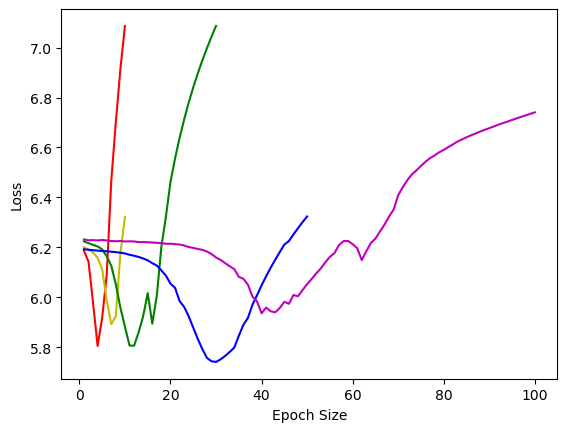

In [21]:
#Learning rate

Epoch_list_short = [x for x in range(1,11)]
Epoch_list_mid = [x for x in range(1,31)]
Epoch_list_long = [x for x in range(1,51)]
Epoch_list_long_long = [x for x in range(1,101)]
#Learning rate 0.00005
lowest_loss = [
    6.231729507446289, 6.228188991546631, 6.228956699371338, 6.227612495422363, 6.229526996612549,
    6.227306365966797, 6.225395679473877, 6.224236965179443, 6.225518226623535, 6.223486423492432,
    6.224047660827637, 6.223669052124023, 6.221007347106934, 6.221083641052246, 6.22042179107666,
    6.219142913818359, 6.218081951141357, 6.216816425323486, 6.214277267456055, 6.214404106140137,
    6.212663650512695, 6.211075782775879, 6.207221508026123, 6.201199054718018, 6.197707653045654,
    6.193297386169434, 6.189899444580078, 6.183038234710693, 6.1732587814331055, 6.159226894378662,
    6.149302959442139, 6.136756420135498, 6.124095916748047, 6.112703323364258, 6.081940174102783,
    6.073904991149902, 6.050360679626465, 6.002722263336182, 5.983165264129639, 5.935515403747559,
    5.958646297454834, 5.943641662597656, 5.939802169799805, 5.957111835479736, 5.981748104095459,
    5.973896026611328, 6.00885009765625, 6.004019260406494, 6.028904914855957, 6.052630424499512,
    6.073485851287842, 6.095391273498535, 6.115278244018555, 6.140076160430908, 6.162001609802246,
    6.177115440368652, 6.208897590637207, 6.224905490875244, 6.22553825378418, 6.212630271911621,
    6.19635009765625, 6.148804187774658, 6.184508323669434, 6.217309951782227, 6.235137462615967,
    6.263626575469971, 6.291079521179199, 6.323797702789307, 6.351808071136475, 6.4090986251831055,
    6.4409499168396, 6.469165802001953, 6.4918975830078125, 6.508532524108887, 6.526401996612549,
    6.542928695678711, 6.557346343994141, 6.568134784698486, 6.580964088439941, 6.590479373931885,
    6.601415157318115, 6.612240791320801, 6.623744487762451, 6.6322784423828125, 6.640961647033691,
    6.648881912231445, 6.656289577484131, 6.663783550262451, 6.670900344848633, 6.677488327026367,
    6.684428691864014, 6.691431045532227, 6.697839736938477, 6.703726291656494, 6.710322856903076,
    6.716891765594482, 6.722888946533203, 6.728874206542969, 6.734745979309082, 6.740909576416016
]

#Learning rate 0.0001
low_loss = batch_512 = [
    6.192203044891357, 6.190314769744873, 6.188745498657227, 6.186720371246338, 6.1852126121521,
    6.184574604034424, 6.182371139526367, 6.180751323699951, 6.178526401519775, 6.175586700439453,
    6.170106887817383, 6.166388988494873, 6.161497116088867, 6.1553568840026855, 6.147785663604736,
    6.136656284332275, 6.12692403793335, 6.1074748039245605, 6.086592197418213, 6.054471492767334,
    6.03786039352417, 5.98466157913208, 5.961151123046875, 5.9235968589782715, 5.87762975692749,
    5.8328328132629395, 5.792041778564453, 5.756974220275879, 5.743349552154541, 5.740853786468506,
    5.7511372566223145, 5.764797687530518, 5.780789852142334, 5.798075199127197, 5.845339298248291,
    5.889374732971191, 5.917327404022217, 5.969769477844238, 6.008025169372559, 6.048081398010254,
    6.084068298339844, 6.118463039398193, 6.150363445281982, 6.181362628936768, 6.211269855499268,
    6.225076198577881, 6.251622200012207, 6.2768402099609375, 6.300896167755127, 6.32359504699707
]
#Learning rate 0.0003
mid_loss = [6.2239990234375,6.216647148132324,6.209654331207275,6.203518867492676,6.192065715789795,6.163589000701904,6.126288414001465,6.051880836486816,5.958495140075684,5.882617950439453,5.806708812713623,5.805641174316406,5.859466552734375,5.924002170562744,6.01662015914917,5.8942551612854,6.006546497344971,6.201990127563477,6.32350492477417,6.462177276611328,6.555911540985107,6.638702392578125,6.71204948425293,6.779936790466309,6.841231822967529,6.897190093994141,6.949131011962891,6.997842311859131,7.043798923492432,7.087125301361084]
#Learning rate 0.0005
high_loss = [6.200469017028809, 6.190797328948975,6.179993152618408,6.157564640045166,6.112344264984131,5.988590717315674,5.892480373382568,5.924180030822754,6.176090717315674,6.3208088874816895]
#Learning rate 0.001
very_high_loss = [6.186917781829834, 6.1429266929626465, 5.977673053741455, 5.804806709289551, 5.918024063110352, 6.089465141296387, 6.466081142425537, 6.701893329620361, 6.913250923156738, 7.087080955505371]

plt.plot(Epoch_list_short, very_high_loss,color='r', label='0.001')
plt.plot(Epoch_list_short, high_loss, color='y', label='0.0005') 
plt.plot(Epoch_list_mid, mid_loss, color='g', label='0.0003') 
plt.plot(Epoch_list_long, low_loss, color='b', label='0.0001') 
plt.plot(Epoch_list_long_long, lowest_loss, color='m', label='0.00005') 
plt.xlabel('Epoch Size')
plt.ylabel('Loss')
plt.show()